# OpenSpartan Workshop Datafile Analysis

One of the staples of any competitive Halo events is the sheer volume of stats that are generated about various participating teams and players. Both viewers and players alike enjoy seeing the performance through an comprehensive lens, dissecting the nuances of individual performance through a myriad of post-match signals.

For the purposes of this notebook, we dive into the **historical metrics** derived from data provided by the Halo Infinite API post-match and captured in [OpenSpartan Workshop](https://github.com/openspartan/openspartan-workshop). Immediate match results are captured through the existing match stats APIs and are components of the historical ones. 


## Tenets/Principles

- **Actionable**. Metrics can be acted on by the player or anyone that analyzes the data.
- **Auditable**. Metrics can be easily verified to be true and accurate.
- **Accessible**. Anyone, both in the audience as well as in the player corpus can understand the metrics.

## Metrics & analysis

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Make sure to substitute `xuid` with the XUID for your own player.

In [2]:
xuid = 'xuid(YOUR_XUID)'

Next, point to your local database file:

In [3]:
database_path = "C:\\Users\\YOUR_USERNAME\\AppData\\Local\\OpenSpartan.Workshop\\data\\YOUR_XUID.db"
connection = sqlite3.connect(database_path)

### K/D/A compared to the team (last 100 matches)

In [4]:
sql_query = f"""
SELECT
        json_extract(player.value, '$.PlayerId') AS PlayerId,
        MatchStats.MatchId,
        strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
        json_extract(teams.value, '$.TeamId') AS TeamId,
        json_extract(teams.value, '$.Stats.CoreStats.KDA') AS TeamKDA,
        json_extract(player.value, '$.PlayerTeamStats[0].TeamId') AS PlayerTeamId,
        json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.KDA') AS PlayerKDA
    FROM
        MatchStats,
        json_each(MatchStats.Players) AS player,
        json_each(MatchStats.Teams) AS teams
    WHERE
        json_extract(player.value, '$.PlayerId') IS NOT NULL
        AND json_extract(teams.value, '$.TeamId') IS NOT NULL
        AND json_extract(player.value, '$.PlayerTeamStats[0].TeamId') = json_extract(teams.value, '$.TeamId')
        AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC
LIMIT 100
"""

In [5]:
df = pd.read_sql_query(sql_query, connection)
df = df.dropna(subset=['PlayerKDA', 'TeamKDA'])
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

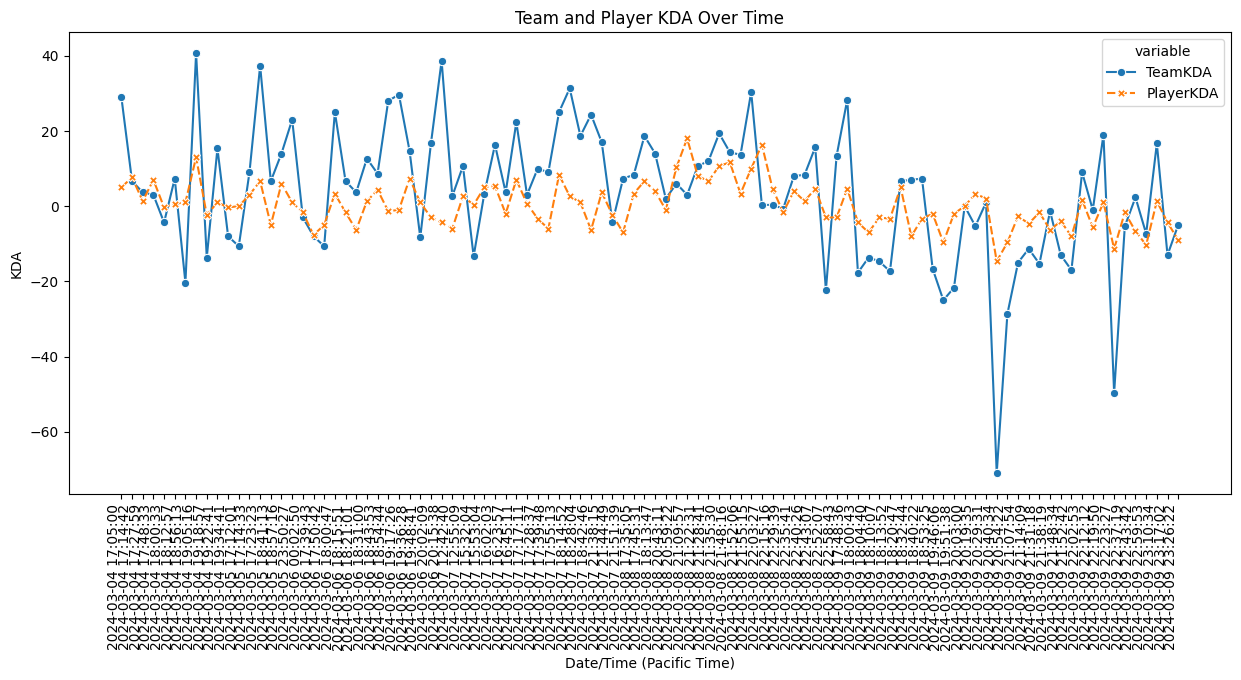

In [6]:
plt.figure(figsize=(15, 6))
plot = sns.lineplot(x='MatchDateTime', y='value', hue='variable', style='variable',
                    markers=True, data=pd.melt(df, id_vars=['MatchDateTime'], value_vars=['TeamKDA', 'PlayerKDA']))

plt.xticks(rotation=90, ha='right')
plt.title('Team and Player KDA Over Time')
plt.xlabel('Date/Time (Pacific Time)')
plt.ylabel('KDA')
plt.show()

### Monthly average and median KDA compared to average KDA of teams player has been on

In [7]:
sql_query = f"""
SELECT
        json_extract(player.value, '$.PlayerId') AS PlayerId,
        MatchStats.MatchId,
        strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
        json_extract(teams.value, '$.TeamId') AS TeamId,
        json_extract(teams.value, '$.Stats.CoreStats.KDA') AS TeamKDA,
        json_extract(player.value, '$.PlayerTeamStats[0].TeamId') AS PlayerTeamId,
        json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.KDA') AS PlayerKDA
    FROM
        MatchStats,
        json_each(MatchStats.Players) AS player,
        json_each(MatchStats.Teams) AS teams
    WHERE
        json_extract(player.value, '$.PlayerId') IS NOT NULL
        AND json_extract(teams.value, '$.TeamId') IS NOT NULL
        AND json_extract(player.value, '$.PlayerTeamStats[0].TeamId') = json_extract(teams.value, '$.TeamId')
        AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC
"""

In [8]:
df = pd.read_sql_query(sql_query, connection)
df = df.dropna(subset=['PlayerKDA', 'TeamKDA'])
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

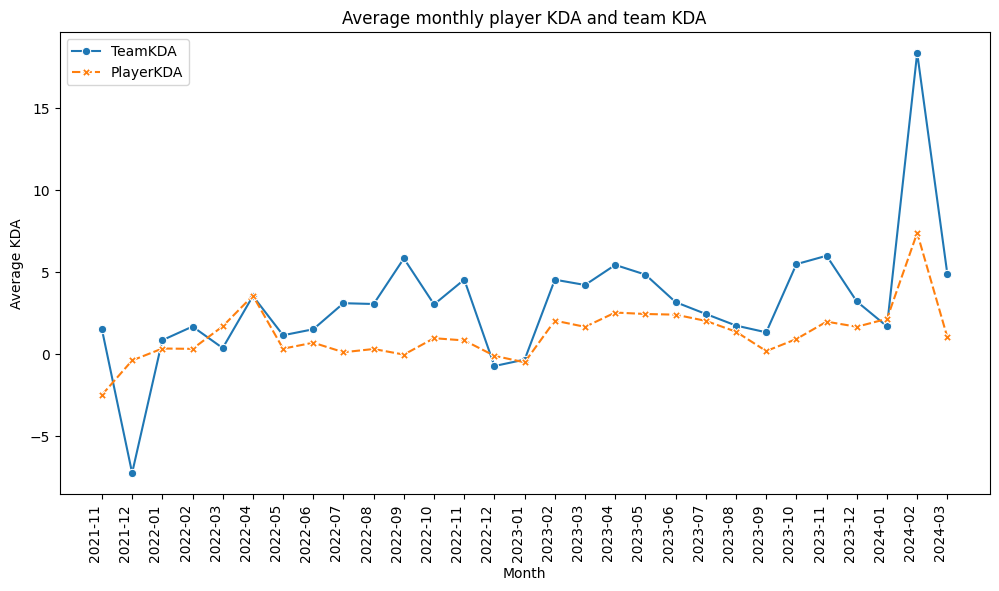

In [9]:
df['MatchDateTime'] = pd.to_datetime(df['MatchDateTime'])
df['YearMonth'] = df['MatchDateTime'].dt.to_period('M')

df = df.dropna(subset=['PlayerKDA', 'TeamKDA'])

average_kda_per_month = df.groupby('YearMonth')[['TeamKDA', 'PlayerKDA']].mean().reset_index()

melted_df = pd.melt(average_kda_per_month, id_vars=['YearMonth'], var_name='KDA Type', value_name='KDA')
melted_df['KDA'] = pd.to_numeric(melted_df['KDA'], errors='coerce')

plt.figure(figsize=(12, 6))
plot = sns.lineplot(x=melted_df['YearMonth'].astype(str), y='KDA', hue='KDA Type', style='KDA Type',
                    markers=True, data=melted_df)

plt.title('Average monthly player KDA and team KDA')
plt.xlabel('Month')
plt.ylabel('Average KDA')
plt.legend()
plt.xticks(rotation=90, ha='right')
plt.show()

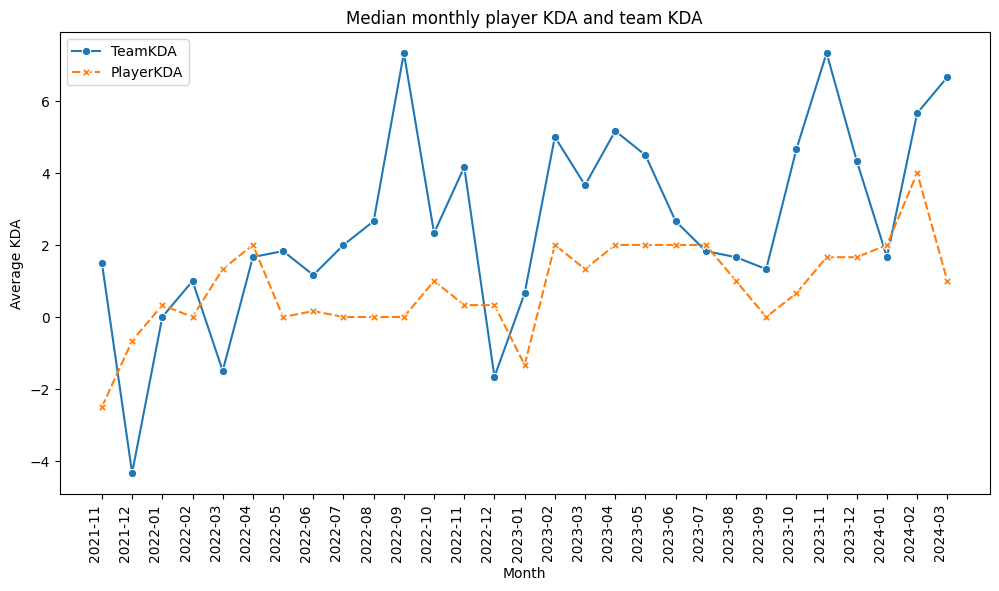

In [10]:
average_kda_per_month = df.groupby('YearMonth')[['TeamKDA', 'PlayerKDA']].median().reset_index()

melted_df = pd.melt(average_kda_per_month, id_vars=['YearMonth'], var_name='KDA Type', value_name='KDA')
melted_df['KDA'] = pd.to_numeric(melted_df['KDA'], errors='coerce')

plt.figure(figsize=(12, 6))
plot = sns.lineplot(x=melted_df['YearMonth'].astype(str), y='KDA', hue='KDA Type', style='KDA Type',
                    markers=True, data=melted_df)

plt.title('Median monthly player KDA and team KDA')
plt.xlabel('Month')
plt.ylabel('Average KDA')
plt.legend()
plt.xticks(rotation=90, ha='right')
plt.show()

### [`CTF` 🚩] Comparison between time spent as flag carrier vs. team average (last 100 matches)

In [11]:
sql_query = f"""
SELECT
    json_extract(player.value, '$.PlayerId') AS PlayerId,
    MatchStats.MatchId,
    strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
    json_extract(teams.value, '$.TeamId') AS TeamId,
    json_extract(player.value, '$.PlayerTeamStats[0].TeamId') AS PlayerTeamId,
    CAST(REPLACE(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CaptureTheFlagStats.TimeAsFlagCarrier'), 'PT', '') AS REAL) AS TimeAsFlagCarrier,
    CAST(REPLACE(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'PT', '') AS REAL) AS AverageLifeDuration,
    (SELECT AVG(CAST(REPLACE(json_extract(player_avg.value, '$.PlayerTeamStats[0].Stats.CaptureTheFlagStats.TimeAsFlagCarrier'), 'PT', '') AS REAL))
     FROM json_each(MatchStats.Players) AS player_avg
     WHERE json_extract(player_avg.value, '$.PlayerId') IS NOT NULL
       AND json_extract(player_avg.value, '$.PlayerTeamStats[0].TeamId') = json_extract(teams.value, '$.TeamId')
       AND json_extract(player_avg.value, '$.PlayerTeamStats[0].Stats.CaptureTheFlagStats.TimeAsFlagCarrier') IS NOT NULL
    ) AS AvgTimeAsFlagCarrier
FROM
    MatchStats,
    json_each(MatchStats.Players) AS player,
    json_each(MatchStats.Teams) AS teams
WHERE
    json_extract(player.value, '$.PlayerId') IS NOT NULL
	AND TimeAsFlagCarrier IS NOT NULL
    AND json_extract(teams.value, '$.TeamId') IS NOT NULL
    AND json_extract(player.value, '$.PlayerTeamStats[0].TeamId') = json_extract(teams.value, '$.TeamId')
    AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC
LIMIT 100
"""

In [12]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

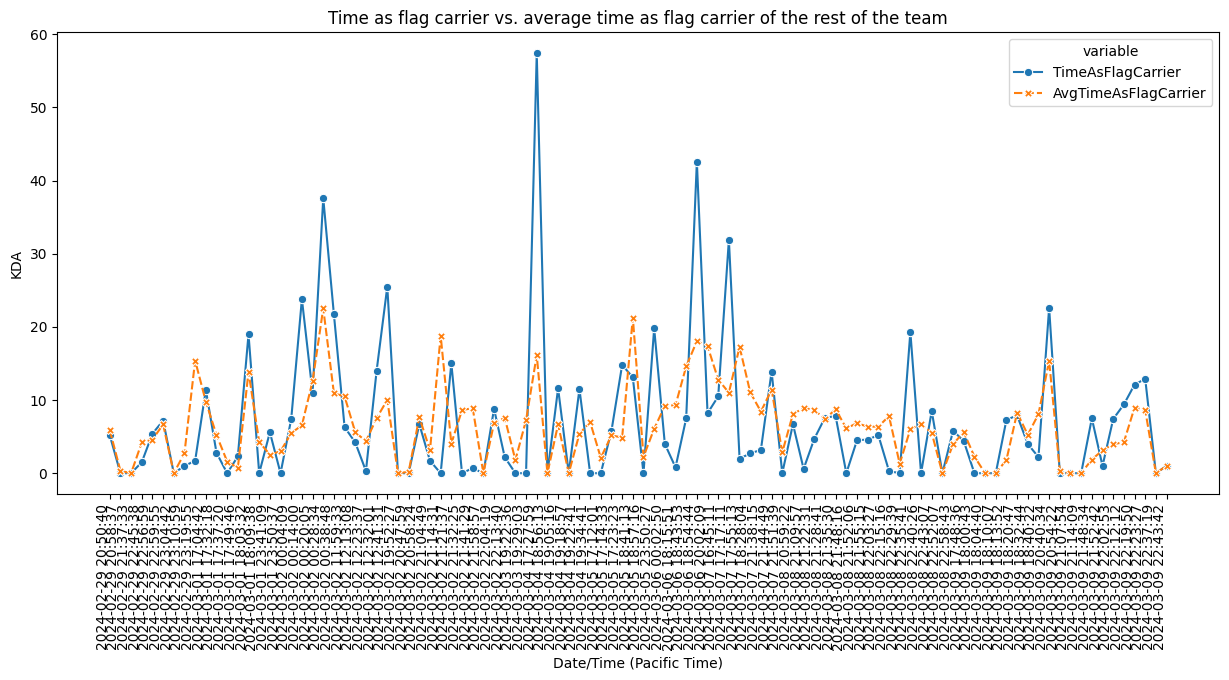

In [13]:
plt.figure(figsize=(15, 6))
plot = sns.lineplot(x='MatchDateTime', y='value', hue='variable', style='variable',
                    markers=True, data=pd.melt(df, id_vars=['MatchDateTime'], value_vars=['TimeAsFlagCarrier', 'AvgTimeAsFlagCarrier']))

plt.xticks(rotation=90, ha='right')
plt.title('Time as flag carrier vs. average time as flag carrier of the rest of the team')
plt.xlabel('Date/Time (Pacific Time)')
plt.ylabel('KDA')
plt.show()

### [`CTF` 🚩] Correlation between time spent as a flag carrier, time alive, and outcome

In [14]:
sql_query = f"""
SELECT
    json_extract(player.value, '$.PlayerId') AS PlayerId,
    MatchStats.MatchId,
    strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
    json_extract(teams.value, '$.TeamId') AS TeamId,
	json_extract(teams.value, '$.Outcome') AS Outcome,
    json_extract(player.value, '$.PlayerTeamStats[0].TeamId') AS PlayerTeamId,
    CAST(REPLACE(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CaptureTheFlagStats.TimeAsFlagCarrier'), 'PT', '') AS REAL) AS TimeAsFlagCarrier,
    CAST(REPLACE(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'PT', '') AS REAL) AS AverageLifeDuration
FROM
    MatchStats,
    json_each(MatchStats.Players) AS player,
    json_each(MatchStats.Teams) AS teams
WHERE
    json_extract(player.value, '$.PlayerId') IS NOT NULL
	AND TimeAsFlagCarrier IS NOT NULL
    AND json_extract(teams.value, '$.TeamId') IS NOT NULL
    AND json_extract(player.value, '$.PlayerTeamStats[0].TeamId') = json_extract(teams.value, '$.TeamId')
    AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC;
"""

In [15]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

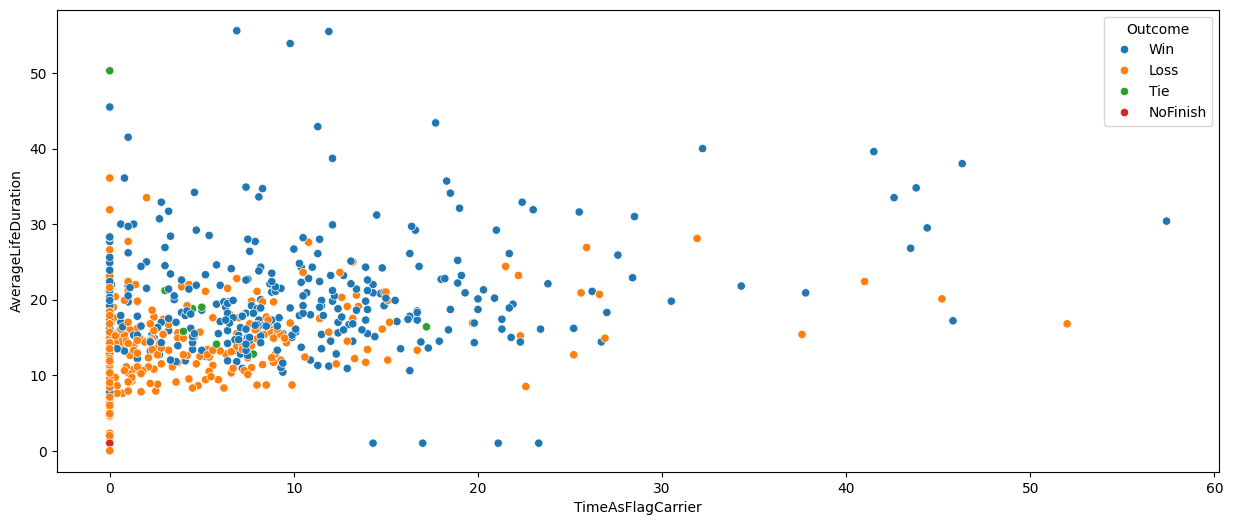

In [16]:
df['Outcome'] = df.apply(lambda row: 'Win' if row['Outcome']==2 else 
                     ('Loss' if row['Outcome']==3 else ('Tie' if row['Outcome']==1 else 'NoFinish')), axis=1)
plt.figure(figsize=(15, 6))
sns.scatterplot(df, x="TimeAsFlagCarrier", y="AverageLifeDuration", hue='Outcome')
plt.show()

### Survival time trends (last 100 matches)

In [17]:
sql_query = f"""
SELECT
    json_extract(player.value, '$.PlayerId') AS PlayerId,
    MatchStats.MatchId,
    strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
    CAST(REPLACE(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'PT', '') AS REAL) AS AverageLifeDuration
FROM
    MatchStats,
    json_each(MatchStats.Players) AS player
WHERE
    json_extract(player.value, '$.PlayerId') IS NOT NULL
    AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC
LIMIT 100
"""

In [18]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

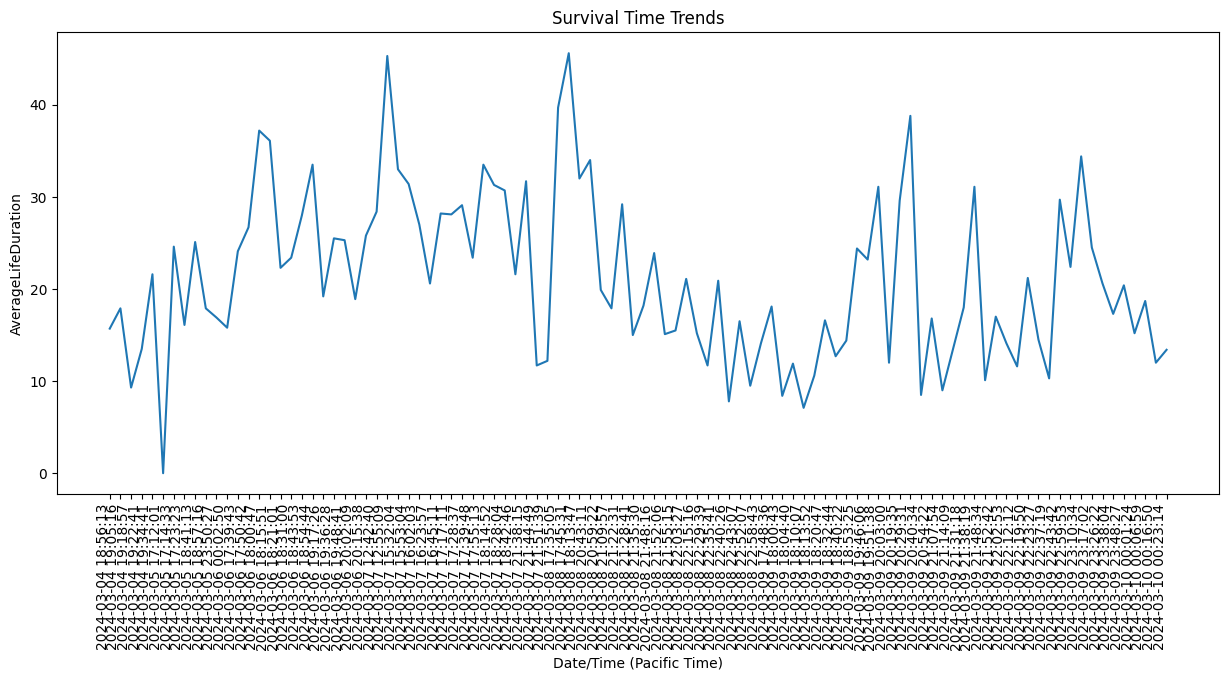

In [19]:
plt.figure(figsize=(15, 6))
plot = sns.lineplot(x='MatchDateTime', y='AverageLifeDuration', data=df)

plt.xticks(rotation=90, ha='right')
plt.title('Survival Time Trends')
plt.xlabel('Date/Time (Pacific Time)')
plt.show()

### Power weapon dominance over time (last 100 matches)

In [20]:
sql_query = f"""
SELECT
    json_extract(player.value, '$.PlayerId') AS PlayerId,
    MatchStats.MatchId,
    strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
    json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Kills') AS Kills,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.PowerWeaponKills') AS PowerWeaponKills
FROM
    MatchStats,
    json_each(MatchStats.Players) AS player
WHERE
    json_extract(player.value, '$.PlayerId') IS NOT NULL
    AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC
LIMIT 100
"""

In [21]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

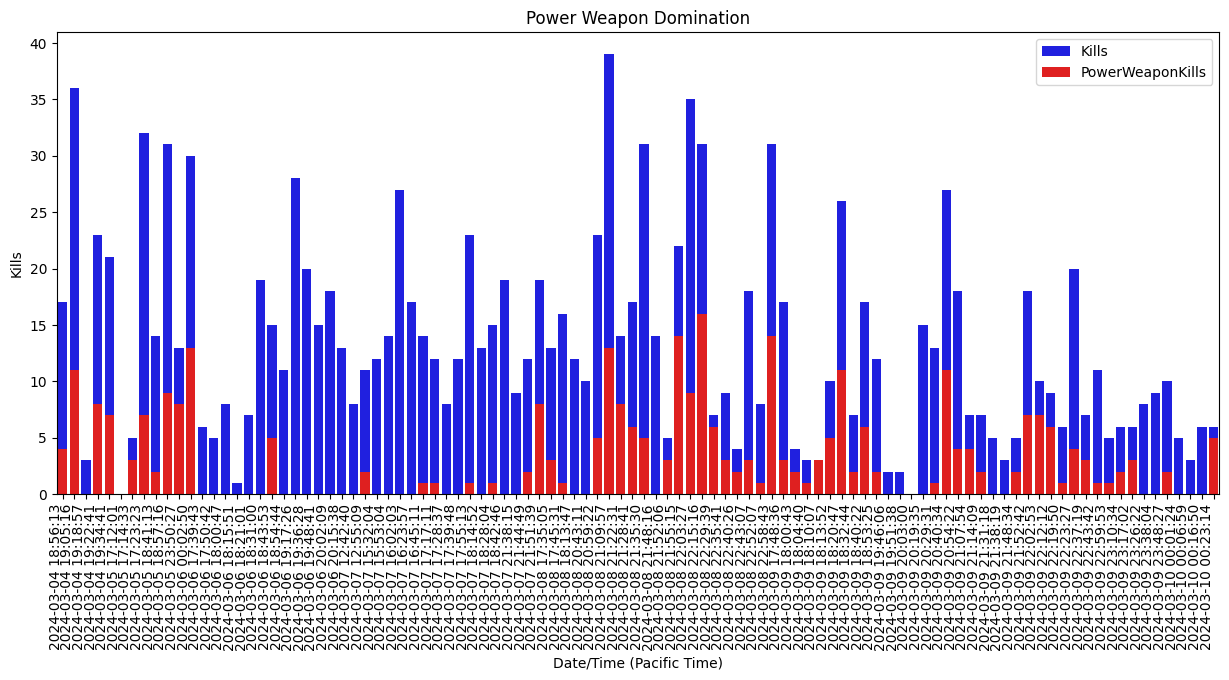

In [22]:
# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Plotting columns with labels
sns.barplot(x=df["MatchDateTime"], y=df["Kills"], color='b', label='Kills', ax=ax)
sns.barplot(x=df["MatchDateTime"], y=df["PowerWeaponKills"], color='r', label='PowerWeaponKills', ax=ax)

# Show the legend
ax.legend()

# Customize the plot
plt.xticks(rotation=90, ha='right')
plt.title('Power Weapon Domination')
plt.xlabel('Date/Time (Pacific Time)')

# Display the plot
plt.show()

### Performance over expected K/D over time (last 50 matches)

In [23]:
sql_query = f"""
SELECT
    pm.MatchId,
    json_extract(pmstats.value, '$.Id') AS PlayerId,
    json_extract(pmstats.value, '$.Result.StatPerformances.Deaths.Count') AS Deaths,
    json_extract(pmstats.value, '$.Result.StatPerformances.Kills.Count') AS Kills,
    json_extract(pmstats.value, '$.Result.StatPerformances.Deaths.Expected') AS ExpectedDeaths,
    json_extract(pmstats.value, '$.Result.StatPerformances.Kills.Expected') AS ExpectedKills,
    json_extract(mstats.MatchInfo, '$.StartTime') AS MatchDateTime
FROM
    PlayerMatchStats pm
JOIN
    MatchStats mstats ON pm.MatchId = mstats.MatchId
JOIN
    json_each(pm.PlayerStats) AS pmstats
WHERE
    json_extract(pmstats.value, '$.Id') = '{xuid}'
	AND ExpectedKills IS NOT 'NaN'
	AND ExpectedDeaths IS NOT 'NaN'
	AND ExpectedKills IS NOT NULL
	AND ExpectedDeaths IS NOT NULL
ORDER BY MatchDateTime DESC
LIMIT 50
"""

In [24]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

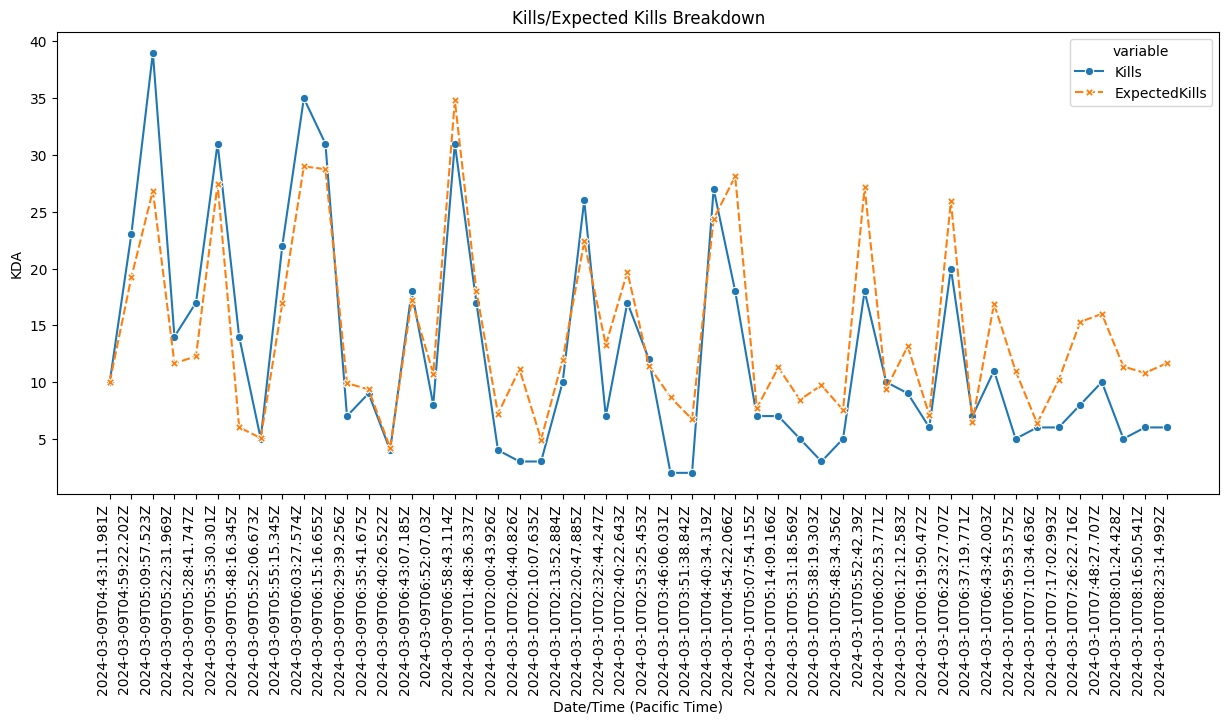

In [25]:
plt.figure(figsize=(15, 6))
plot = sns.lineplot(x='MatchDateTime', y='value', hue='variable', style='variable',
                    markers=True, data=pd.melt(df, id_vars=['MatchDateTime'], value_vars=['Kills', 'ExpectedKills']))

plt.xticks(rotation=90, ha='right')
plt.title('Kills/Expected Kills Breakdown')
plt.xlabel('Date/Time (Pacific Time)')
plt.ylabel('KDA')
plt.show()

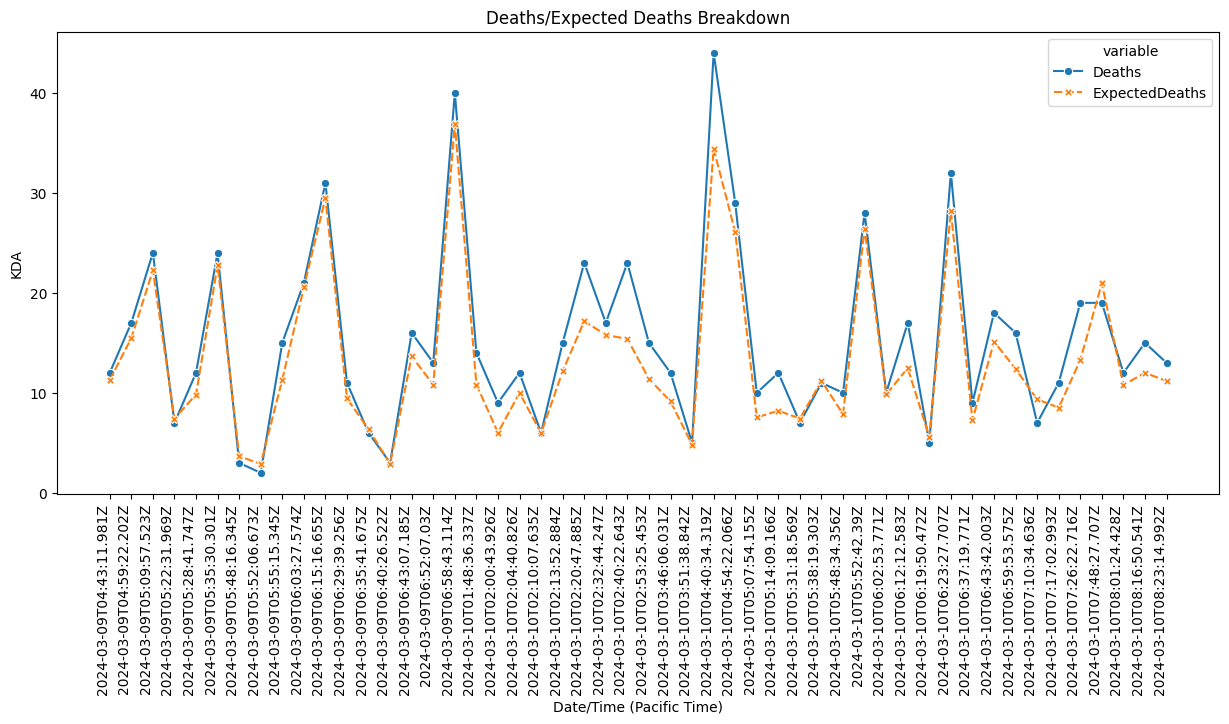

In [26]:
plt.figure(figsize=(15, 6))
plot = sns.lineplot(x='MatchDateTime', y='value', hue='variable', style='variable',
                    markers=True, data=pd.melt(df, id_vars=['MatchDateTime'], value_vars=['Deaths', 'ExpectedDeaths']))

plt.xticks(rotation=90, ha='right')
plt.title('Deaths/Expected Deaths Breakdown')
plt.xlabel('Date/Time (Pacific Time)')
plt.ylabel('KDA')
plt.show()

### Map-specific adaptability over time

In [27]:
sql_query = f"""
WITH MapStats AS (
    SELECT
        m.MatchId,
        CASE json_extract(m.MatchInfo, '$.GameVariantCategory')
            WHEN 1 THEN 'Campaign'
            WHEN 2 THEN 'Forge'
            WHEN 3 THEN 'Academy'
            WHEN 4 THEN 'AcademyTutorial'
            WHEN 5 THEN 'AcademyPractice'
            WHEN 6 THEN 'MultiplayerSlayer'
            WHEN 7 THEN 'MultiplayerAttrition'
            WHEN 8 THEN 'MultiplayerElimination'
            WHEN 9 THEN 'MultiplayerFiesta'
            WHEN 10 THEN 'MultiplayerSwat'
            WHEN 11 THEN 'MultiplayerStrongholds'
            WHEN 12 THEN 'MultiplayerBastion'
            WHEN 13 THEN 'MultiplayerKingOfTheHill'
            WHEN 14 THEN 'MultiplayerTotalControl'
            WHEN 15 THEN 'MultiplayerCtf'
            WHEN 16 THEN 'MultiplayerAssault'
            WHEN 17 THEN 'MultiplayerExtraction'
            WHEN 18 THEN 'MultiplayerOddball'
            WHEN 19 THEN 'MultiplayerStockpile'
            WHEN 20 THEN 'MultiplayerJuggernaut'
            WHEN 21 THEN 'MultiplayerRegicide'
            WHEN 22 THEN 'MultiplayerInfection'
            WHEN 23 THEN 'MultiplayerEscort'
            WHEN 24 THEN 'MultiplayerGunGame'
            WHEN 25 THEN 'MultiplayerGrifball'
            WHEN 26 THEN 'MultiplayerRace'
            WHEN 27 THEN 'MultiplayerPrototype'
            WHEN 28 THEN 'Test'
            WHEN 29 THEN 'TestAcademy'
            WHEN 30 THEN 'TestAudio'
            WHEN 31 THEN 'TestCampaign'
            WHEN 32 THEN 'TestEngine'
            WHEN 33 THEN 'TestForge'
            WHEN 34 THEN 'TestGraphics'
            WHEN 35 THEN 'TestMultiplayer'
            WHEN 36 THEN 'TestSandbox'
            WHEN 37 THEN 'AcademyTraining'
            WHEN 38 THEN 'AcademyWeaponDrill'
            WHEN 39 THEN 'MultiplayerLandGrab'
            WHEN 42 THEN 'MultiplayerFirefight'
            ELSE 'Unknown'
        END AS GameVariantCategory,
        json_extract(m.MatchInfo, '$.MapVariant.AssetId') AS MapVariantAssetId,
        json_extract(p_stats.value, '$.Outcome') AS Outcome,
        json_extract(p_stats.value, '$.PlayerId') AS PlayerId,
        COALESCE(map.PublicName, 'Unknown') AS MapName
    FROM
        MatchStats m
    JOIN
        json_each(m.Players) AS p_stats
    LEFT JOIN
        (SELECT
            AssetId,
            PublicName
        FROM
            Maps
        GROUP BY
            AssetId) AS map ON map.AssetId = json_extract(m.MatchInfo, '$.MapVariant.AssetId')
    WHERE
        json_extract(p_stats.value, '$.PlayerId') = '{xuid}'
)

SELECT
    GameVariantCategory,
    MapName,
    COUNT(DISTINCT MatchId) AS TotalMatches,
    SUM(CASE WHEN Outcome = 2 THEN 1 ELSE 0 END) AS Wins,
    CAST(SUM(CASE WHEN Outcome = 2 THEN 1 ELSE 0 END) AS REAL) / COUNT(*) AS WinPercentage
FROM
    MapStats
GROUP BY
    GameVariantCategory, MapName
ORDER BY
    WinPercentage DESC;
"""

In [28]:
df = pd.read_sql_query(sql_query, connection)

In [29]:
# Pivot the DataFrame to have GameVariantCategory as rows, MapName as columns, and WinPercentage as values
heatmap_data = df.pivot(index='GameVariantCategory', columns='MapName', values='WinPercentage')
# Replace NaN values with zeros
heatmap_data = heatmap_data.fillna(0)

Once the image renders, make sure to double click on it to get the full-size, readable version of it.

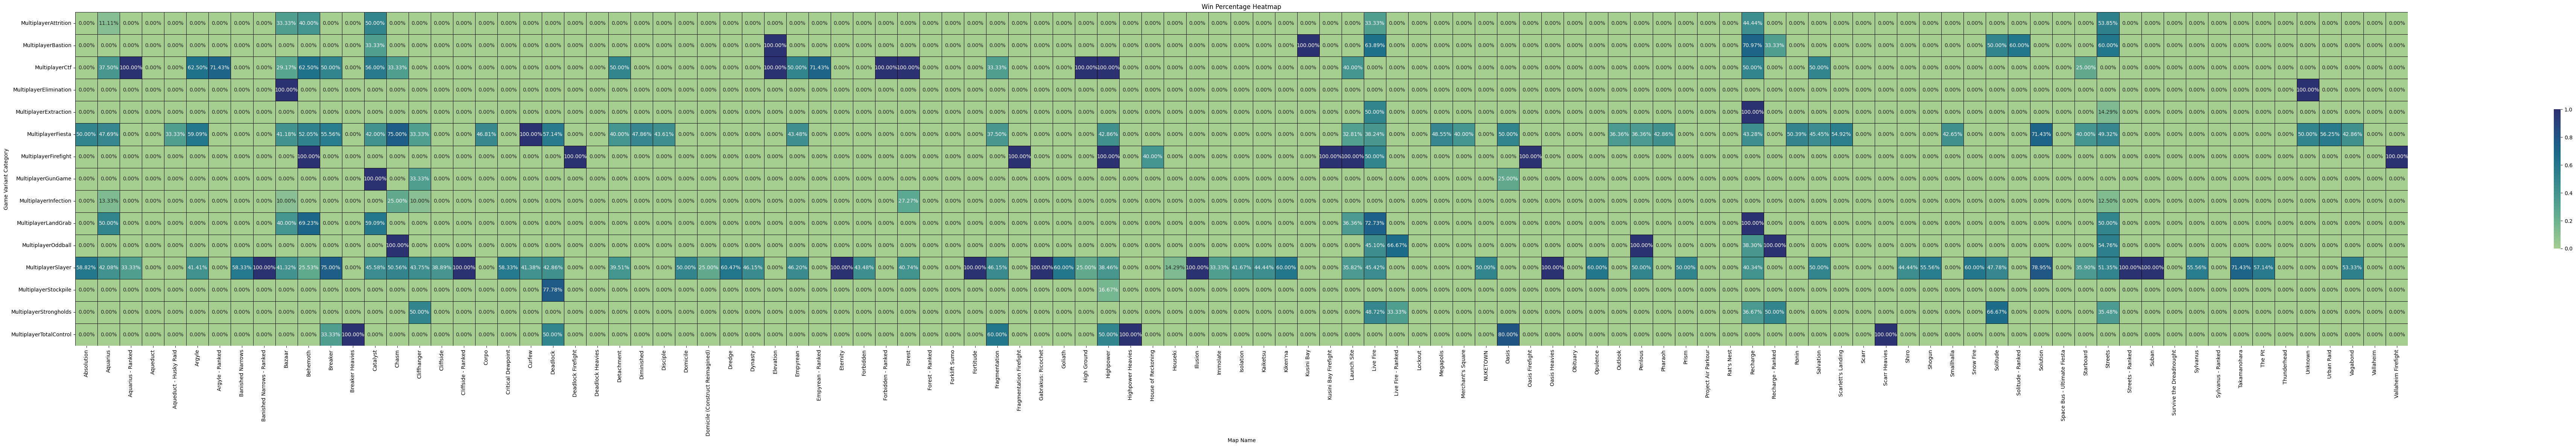

In [30]:
# Create a heatmap
plt.figure(figsize=(100, 12))
sns.heatmap(heatmap_data, cmap='crest', fmt='.2%', linewidths=0.5, linecolor='black', annot=True, square=True, cbar_kws={"shrink": 0.4})
plt.title('Win Percentage Heatmap')
plt.xlabel('Map Name')
plt.ylabel('Game Variant Category')
plt.show()

### Correlation between power weapon kills, kills overall, and outcomes

In [31]:
sql_query = f"""
SELECT
    json_extract(player.value, '$.PlayerId') AS PlayerId,
    MatchStats.MatchId,
    strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
	json_extract(player.value, '$.Outcome') AS Outcome,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.PowerWeaponKills') PowerWeaponKills,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Kills') Kills
FROM
    MatchStats,
    json_each(MatchStats.Players) AS player
WHERE
    json_extract(player.value, '$.PlayerId') IS NOT NULL
    AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC;
"""

In [32]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

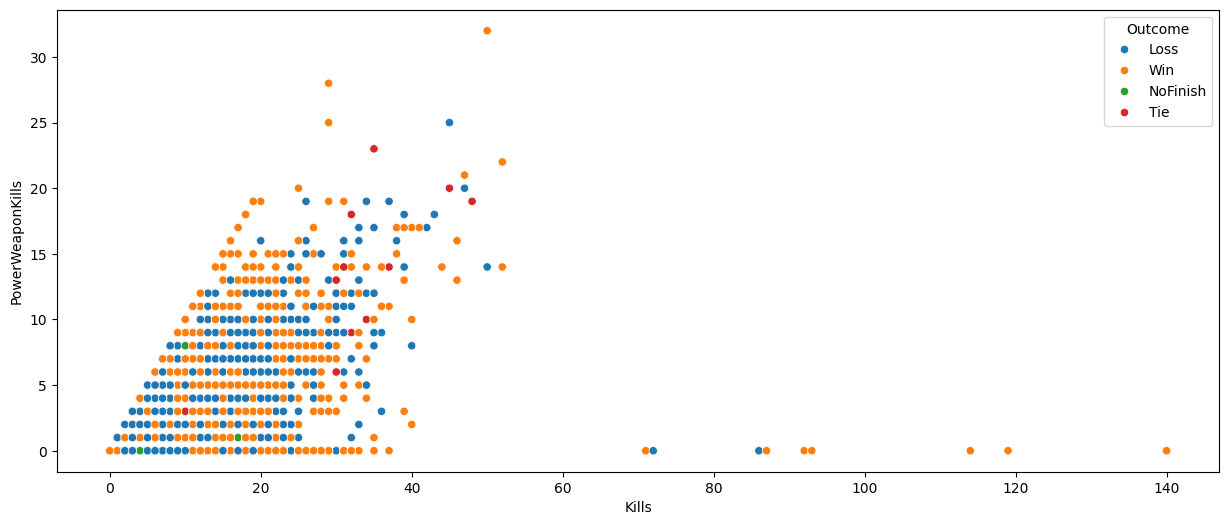

In [33]:
df['Outcome'] = df.apply(lambda row: 'Win' if row['Outcome']==2 else 
                     ('Loss' if row['Outcome']==3 else ('Tie' if row['Outcome']==1 else 'NoFinish')), axis=1)
plt.figure(figsize=(15, 6))
sns.scatterplot(df, x="Kills", y="PowerWeaponKills", hue='Outcome')
plt.show()

### Correlation between accuracy, kills, and outcomes

In [34]:
sql_query = f"""
SELECT
    json_extract(player.value, '$.PlayerId') AS PlayerId,
    MatchStats.MatchId,
    strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
	json_extract(player.value, '$.Outcome') AS Outcome,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Accuracy') Accuracy,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Kills') Kills
FROM
    MatchStats,
    json_each(MatchStats.Players) AS player
WHERE
    json_extract(player.value, '$.PlayerId') IS NOT NULL
    AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC;
"""

In [35]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

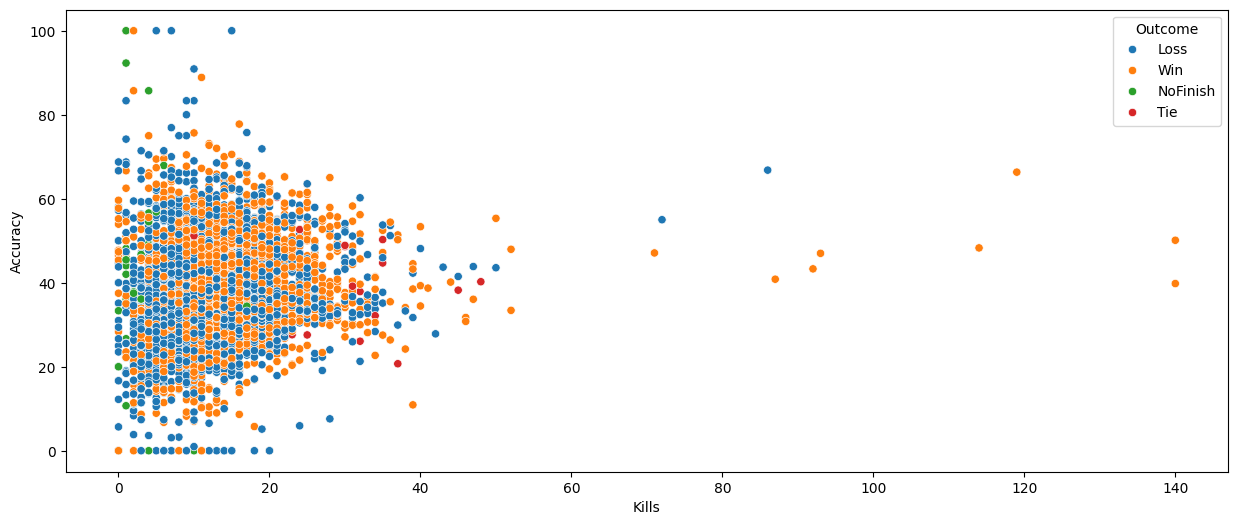

In [36]:
df['Outcome'] = df.apply(lambda row: 'Win' if row['Outcome']==2 else 
                     ('Loss' if row['Outcome']==3 else ('Tie' if row['Outcome']==1 else 'NoFinish')), axis=1)
plt.figure(figsize=(15, 6))
sns.scatterplot(df, x="Kills", y="Accuracy", hue='Outcome')
plt.show()

### Correlation between number of assists, lifetime, and outcomes

In [37]:
sql_query = f"""
SELECT
    json_extract(player.value, '$.PlayerId') AS PlayerId,
    MatchStats.MatchId,
    strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
	json_extract(teams.value, '$.Outcome') AS Outcome,
    json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Accuracy') Assists,
    CAST(REPLACE(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'PT', '') AS REAL) AS AverageLifeDuration
FROM
    MatchStats,
    json_each(MatchStats.Players) AS player,
    json_each(MatchStats.Teams) AS teams
WHERE
    json_extract(player.value, '$.PlayerId') IS NOT NULL
    AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC;
"""

In [38]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

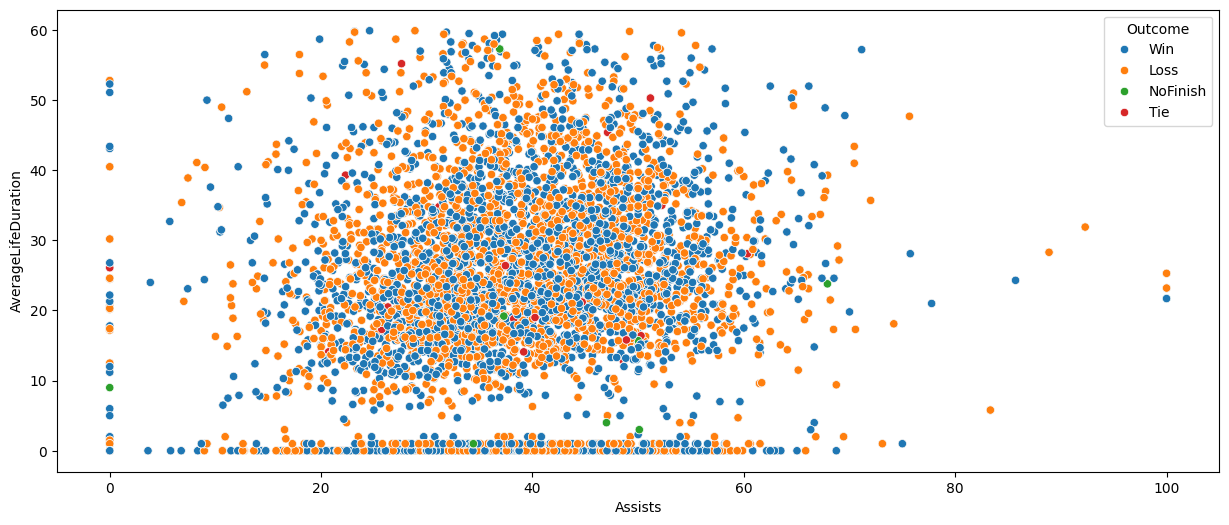

In [39]:
df['Outcome'] = df.apply(lambda row: 'Win' if row['Outcome']==2 else 
                     ('Loss' if row['Outcome']==3 else ('Tie' if row['Outcome']==1 else 'NoFinish')), axis=1)
plt.figure(figsize=(15, 6))
sns.scatterplot(df, x="Assists", y="AverageLifeDuration", hue='Outcome')
plt.show()

### Correlation between time played, lifetime, and outcomes

In [40]:
sql_query = f"""
SELECT
    json_extract(player.value, '$.PlayerId') AS PlayerId,
    MatchStats.MatchId,
    strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
	json_extract(teams.value, '$.Outcome') AS Outcome,
    CAST(REPLACE(json_extract(player.value, '$.ParticipationInfo.TimePlayed'), 'PT', '') AS REAL) AS TimePlayed,
    CAST(REPLACE(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'PT', '') AS REAL) AS AverageLifeDuration
FROM
    MatchStats,
    json_each(MatchStats.Players) AS player,
    json_each(MatchStats.Teams) AS teams
WHERE
    json_extract(player.value, '$.PlayerId') IS NOT NULL
    AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC;
"""

In [41]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

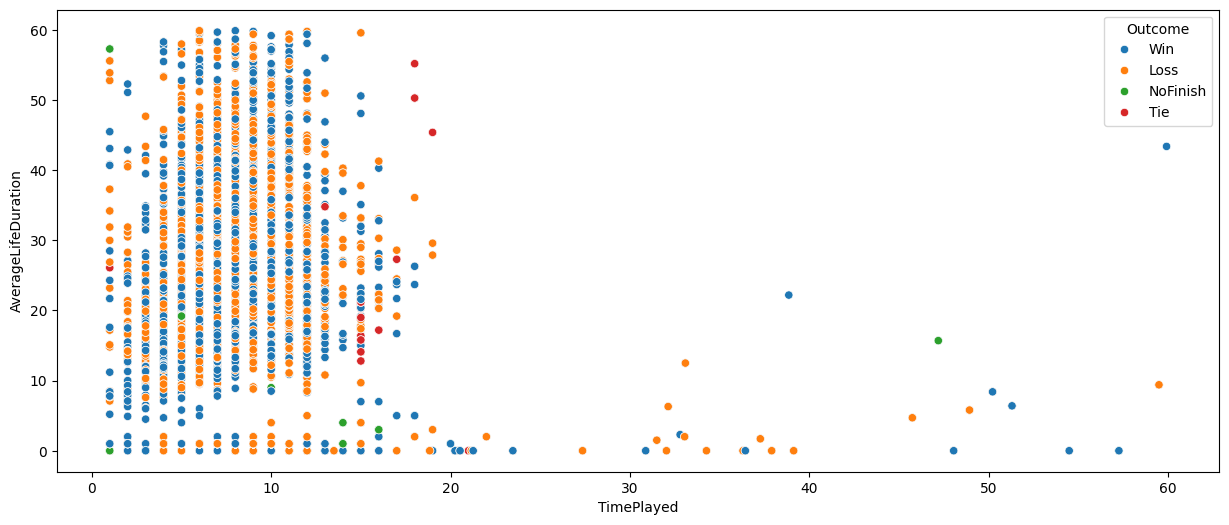

In [42]:
df['Outcome'] = df.apply(lambda row: 'Win' if row['Outcome']==2 else 
                     ('Loss' if row['Outcome']==3 else ('Tie' if row['Outcome']==1 else 'NoFinish')), axis=1)
plt.figure(figsize=(15, 6))
sns.scatterplot(df, x="TimePlayed", y="AverageLifeDuration", hue='Outcome')
plt.show()

### [`CTF` 🚩] Correlation between flag steals, kills, and outcomes

In [43]:
sql_query = f"""
SELECT
    json_extract(player.value, '$.PlayerId') AS PlayerId,
    MatchStats.MatchId,
    strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
    json_extract(teams.value, '$.TeamId') AS TeamId,
	json_extract(teams.value, '$.Outcome') AS Outcome,
    json_extract(player.value, '$.PlayerTeamStats[0].TeamId') AS PlayerTeamId,
    CAST(REPLACE(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CaptureTheFlagStats.FlagSteals'), 'PT', '') AS REAL) AS FlagSteals,
    json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Kills') Kills
FROM
    MatchStats,
    json_each(MatchStats.Players) AS player,
    json_each(MatchStats.Teams) AS teams
WHERE
    json_extract(player.value, '$.PlayerId') IS NOT NULL
	AND FlagSteals IS NOT NULL
    AND json_extract(teams.value, '$.TeamId') IS NOT NULL
    AND json_extract(player.value, '$.PlayerTeamStats[0].TeamId') = json_extract(teams.value, '$.TeamId')
    AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC;
"""

In [44]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

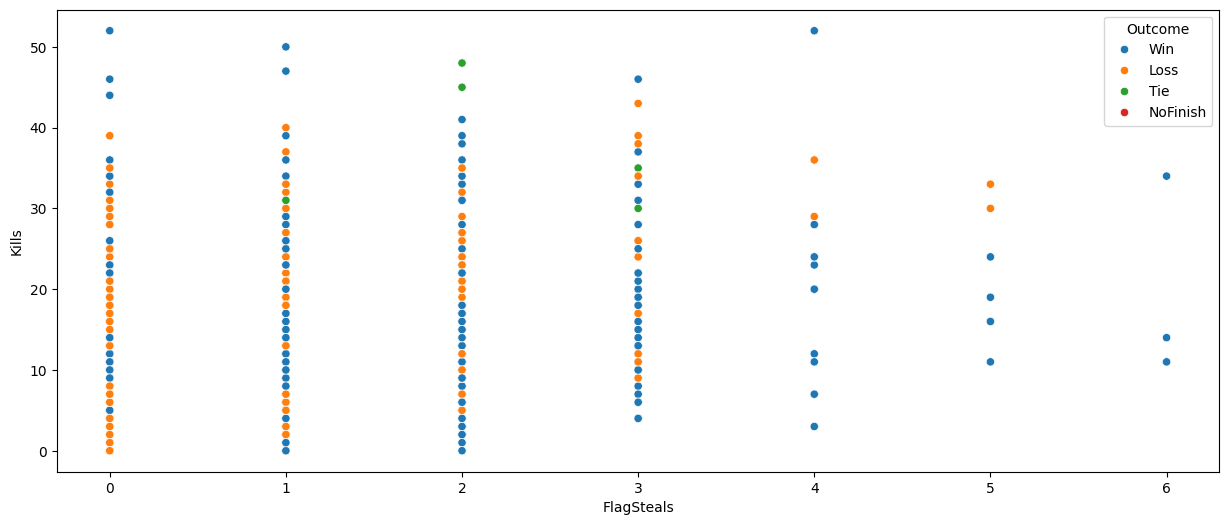

In [45]:
df['Outcome'] = df.apply(lambda row: 'Win' if row['Outcome']==2 else 
                     ('Loss' if row['Outcome']==3 else ('Tie' if row['Outcome']==1 else 'NoFinish')), axis=1)
plt.figure(figsize=(15, 6))
sns.scatterplot(df, x="FlagSteals", y="Kills", hue='Outcome')
plt.show()

### Correlation between medals earned, kills, and outcomes

In [46]:
sql_query = f"""
SELECT
    json_extract(player.value, '$.PlayerId') AS PlayerId,
    MatchStats.MatchId,
    strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
    json_extract(teams.value, '$.Outcome') AS Outcome,
    json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Kills') AS Kills,
    COALESCE(SUM(json_extract(medals.value, '$.Count')),0) AS MedalCount
FROM
    MatchStats
JOIN
    json_each(MatchStats.Players) AS player
JOIN
    json_tree(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Medals') AS medals
JOIN
    json_each(MatchStats.Teams) AS teams
WHERE
    json_extract(player.value, '$.PlayerId') IS NOT NULL
    AND PlayerId = '{xuid}'
GROUP BY
    MatchStats.MatchId
ORDER BY
    MatchDateTime DESC;
"""

In [47]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

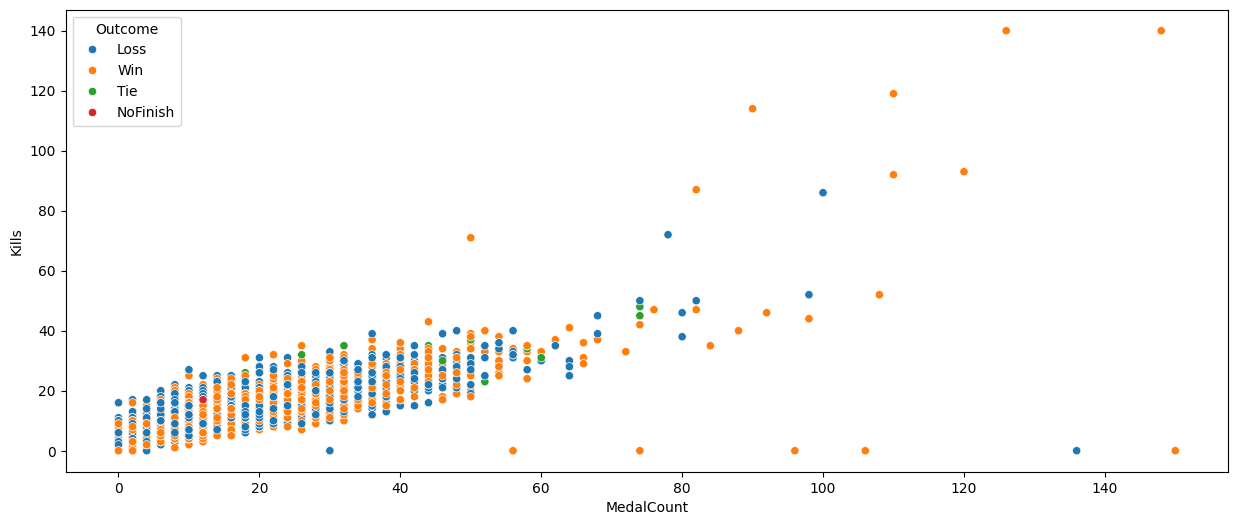

In [48]:
df['Outcome'] = df.apply(lambda row: 'Win' if row['Outcome']==2 else 
                     ('Loss' if row['Outcome']==3 else ('Tie' if row['Outcome']==1 else 'NoFinish')), axis=1)
plt.figure(figsize=(15, 6))
sns.scatterplot(df, x="MedalCount", y="Kills", hue='Outcome')
plt.show()

### Correlation between assists, callout assists, and outcomes

In [49]:
sql_query = f"""
SELECT
    json_extract(player.value, '$.PlayerId') AS PlayerId,
    MatchStats.MatchId,
    strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
	json_extract(teams.value, '$.Outcome') AS Outcome,
    json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Assists') Assists,
    json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.CalloutAssists') CalloutAssists
FROM
    MatchStats,
    json_each(MatchStats.Players) AS player,
    json_each(MatchStats.Teams) AS teams
WHERE
    json_extract(player.value, '$.PlayerId') IS NOT NULL
    AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC;
"""

In [50]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

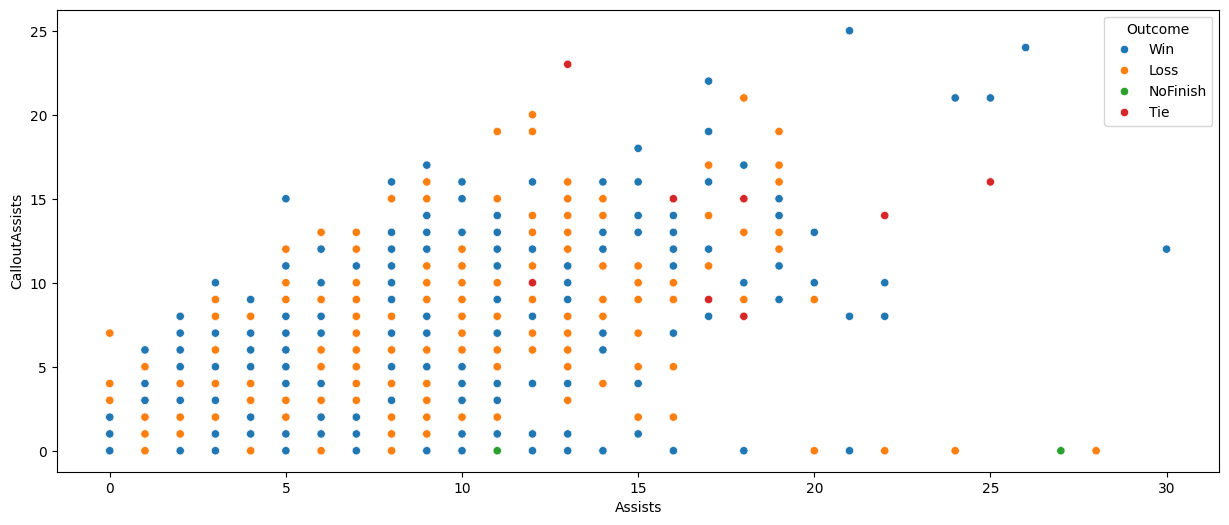

In [51]:
df['Outcome'] = df.apply(lambda row: 'Win' if row['Outcome']==2 else 
                     ('Loss' if row['Outcome']==3 else ('Tie' if row['Outcome']==1 else 'NoFinish')), axis=1)
plt.figure(figsize=(15, 6))
sns.scatterplot(df, x="Assists", y="CalloutAssists", hue='Outcome')
plt.show()

### Correlation between damage dealt/taken and outcomes

In [52]:
sql_query = f"""
SELECT
    json_extract(player.value, '$.PlayerId') AS PlayerId,
    MatchStats.MatchId,
    strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
	json_extract(teams.value, '$.Outcome') AS Outcome,
    json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.DamageTaken') DamageTaken,
    json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.DamageDealt') DamageDealt
FROM
    MatchStats,
    json_each(MatchStats.Players) AS player,
    json_each(MatchStats.Teams) AS teams
WHERE
    json_extract(player.value, '$.PlayerId') IS NOT NULL
    AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC;
"""

In [53]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

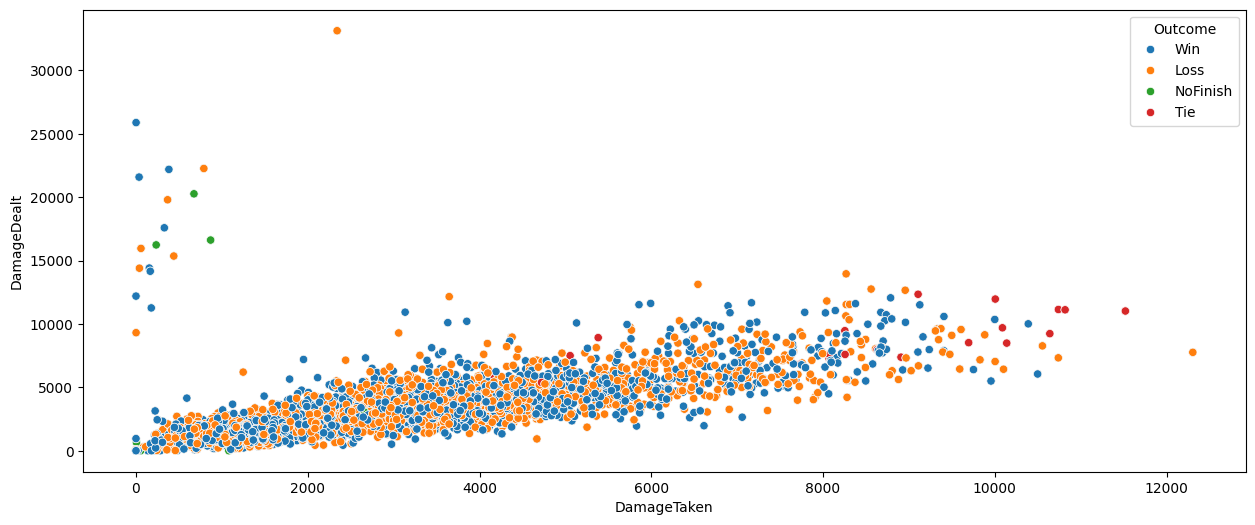

In [54]:
df['Outcome'] = df.apply(lambda row: 'Win' if row['Outcome']==2 else 
                     ('Loss' if row['Outcome']==3 else ('Tie' if row['Outcome']==1 else 'NoFinish')), axis=1)
plt.figure(figsize=(15, 6))
sns.scatterplot(df, x="DamageTaken", y="DamageDealt", hue='Outcome')
plt.show()

### Correlation between average life duration, powerweapon kills, and outcomes

In [55]:
sql_query = f"""
SELECT
    json_extract(player.value, '$.PlayerId') AS PlayerId,
    MatchStats.MatchId,
    strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
	json_extract(player.value, '$.Outcome') AS Outcome,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.PowerWeaponKills') PowerWeaponKills,
	CAST(REPLACE(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'PT', '') AS REAL) AS AverageLifeDuration
FROM
    MatchStats,
    json_each(MatchStats.Players) AS player
WHERE
    json_extract(player.value, '$.PlayerId') IS NOT NULL
    AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC;
"""

In [56]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

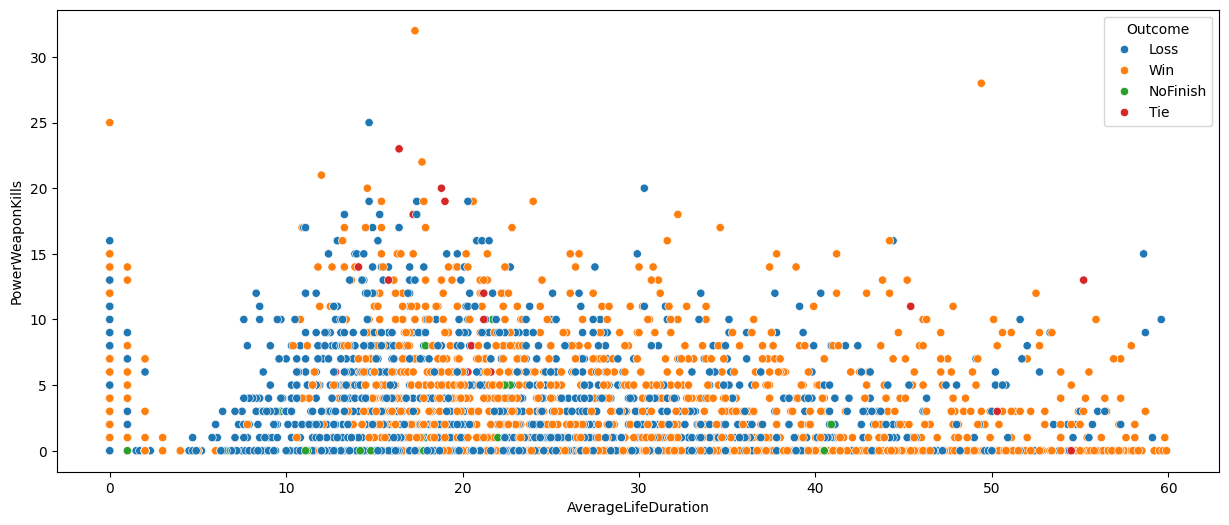

In [57]:
df['Outcome'] = df.apply(lambda row: 'Win' if row['Outcome']==2 else 
                     ('Loss' if row['Outcome']==3 else ('Tie' if row['Outcome']==1 else 'NoFinish')), axis=1)
plt.figure(figsize=(15, 6))
sns.scatterplot(df, x="AverageLifeDuration", y="PowerWeaponKills", hue='Outcome')
plt.show()

### Correlation between accuracy, average life duration, and outcomes

In [58]:
sql_query = f"""
SELECT
    json_extract(player.value, '$.PlayerId') AS PlayerId,
    MatchStats.MatchId,
    strftime('%Y-%m-%d %H:%M:%S', datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime', 'UTC')) AS MatchDateTime,
	json_extract(player.value, '$.Outcome') AS Outcome,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Accuracy') Accuracy,
	CAST(REPLACE(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'PT', '') AS REAL) AS AverageLifeDuration
FROM
    MatchStats,
    json_each(MatchStats.Players) AS player
WHERE
    json_extract(player.value, '$.PlayerId') IS NOT NULL
    AND PlayerId = '{xuid}'
ORDER BY MatchDateTime DESC;
"""

In [59]:
df = pd.read_sql_query(sql_query, connection)
df.sort_values(by='MatchDateTime', inplace=True, ascending=True)

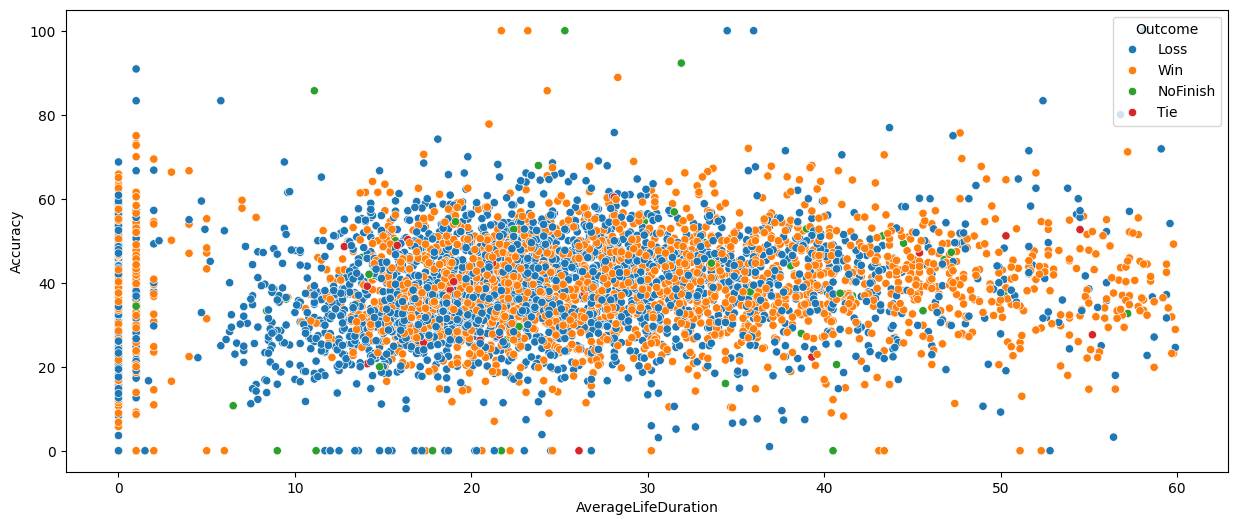

In [60]:
df['Outcome'] = df.apply(lambda row: 'Win' if row['Outcome']==2 else 
                     ('Loss' if row['Outcome']==3 else ('Tie' if row['Outcome']==1 else 'NoFinish')), axis=1)
plt.figure(figsize=(15, 6))
sns.scatterplot(df, x="AverageLifeDuration", y="Accuracy", hue='Outcome')
plt.show()